<img src='./img/logo_fire_workshop.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='40%'></img>

<br>

<a href="./51_sentinel3_slstr_frp.ipynb"><< 51 - Sentinel-3 SLSTR FRP </a><span style="float:right;"><a href="./53_sentinel3_olci_rgb.ipynb">52 - Sentinel-3 OLCI RGB >></a></span>

# Sentinel-3 SLSTR Fire Radiative Power (FRP)

###  Example Chernobyl Fires May 2020

The [Copernicus Near-Real-Time Sentinel 3 Fire Radiative Power](https://navigator.eumetsat.int/product/EO:EUM:DAT:0207) product identifies the location, and quantifies the radiative power, of any hotspot present on land and ocean Earth surfaces, that radiates a heating signal within a pixel size of 1 km2.

All threatening hotspots are identified and characterised within three hours from SLSTR observation sensing time.
The current version of the NRT S3 FRP processor is mainly applicable during the night while only a few daytime granules, with non-saturated background (i.e. no fires) radiance, are processed at this stage. The NRT S3 FRP product will become operational after a higher level of quality and maturity is reached, including the full processing of granules during daytime, a comprehensive global validation, and positive feedback by experts and users.

Get more product specifications [here](https://www.eumetsat.int/website/home/News/DAT_4962463.html).

#### This module has the following outline:
* [1 - Load Sentinel-3 SLSTR FRP data](#load_s3_frp)
* [2 - Load, mask and regrid FRP computed from MWIR channel (3.7 um)](#load_mwir)
* [3 - Load, mask and regrid FRP computed from SWIR channel (2.25 um)](#load_swir)
* [4 - Load, mask and regrid FRP computed from SWIR channel (2.25 um) with SAA filter applied](#load_swir_nosaa)

#### Load required libraries

In [1]:
import xarray as xr

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as pltfacebook
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
from ipynb.fs.full.functions import generate_masked_array, visualize_s3_frp, slstr_frp_gridding

<hr>

## <a id='load_s3_frp'></a>Load Sentinel-3 SLSTR FRP data

Sentinel-3 SLSTR FRP data are disseminated  in `netCDF` format. The first step is to load the data file with xarray's `open_dataset` function.


#### Load `SLSTR FRP` data with xarray's `open_dataset()` function

Once the data file is loaded, you see that the data file has three dimensions: `columns`, `fires` and `rows`. The data and additional information, such as quality flags or latitude and longitude information, is stored as data variables.

There are three variables of interest:
- `FRP_MWIR` - Fire Radiative Power computed from MWIR channel (3.7 um) [MW]
- `FRP_SWIR` - Fire Radiative Power computed from SWIR channel (2.25 um) [MW]
- `FLAG_SWIR_SAA` - Flag values to filter out South Atlantic ANomalies (SAA) & other transient / spurious events, only applicable to FRP SWIR

In [3]:
frp_dir = './eodata/sentinel3/frp/'
frp_xr = xr.open_dataset(frp_dir+'FRP_in_Chernobyl_202000507.nc')
frp_xr

<xarray.Dataset>
Dimensions:                 (columns: 1500, fires: 917, rows: 2052)
Dimensions without coordinates: columns, fires, rows
Data variables:
    i                       (fires) int16 ...
    j                       (fires) int32 ...
    time                    (fires) datetime64[ns] ...
    latitude                (fires) float64 ...
    longitude               (fires) float64 ...
    FRP_MWIR                (fires) float64 ...
    FRP_uncertainty_MWIR    (fires) float64 ...
    transmittance_MWIR      (fires) float64 ...
    FRP_SWIR                (fires) float64 ...
    FRP_uncertainty_SWIR    (fires) float64 ...
    FLAG_SWIR_SAA           (fires) int16 ...
    transmittance_SWIR      (fires) float64 ...
    confidence              (fires) float64 ...
    classification          (fires) uint8 ...
    S7_Fire_pixel_radiance  (fires) float32 ...
    F1_Fire_pixel_radiance  (fires) float32 ...
    used_channel            (fires) uint8 ...
    Radiance_window         (fires) float32 ...
    Glint_angle             (fires) float64 ...
    IFOV_area               (fires) float64 ...
    TCWV                    (fires) float64 ...
    n_window                (fires) int16 ...
    n_water                 (fires) int16 ...
    n_cloud                 (fires) int16 ...
    n_SWIR_fire             (fires) float32 ...
    flags                   (rows, columns) uint32 ...
Attributes:
    title:                  SLSTR Level 2 Product, Fire Radiative Power measu...
    comment:                 
    netCDF_version:         4.2 of Jul  5 2012 17:07:43 $
    product_name:           S3A_SL_2_FRP____20200416T190433_20200416T190941_2...
    institution:            MAR
    source:                 IPF-SL-2-FRP 02.00
    history:                 
    references:             S3MPC ACR FRP 003 - i1r2 - SLSTR L2 Product Data ...
    contact:                ops@eumetsat.int
    creation_time:          2020-04-16T21:53:43Z
    resolution:             [ 1000 1000 ]
    absolute_orbit_number:  21689
    start_time:             2020-04-16T19:04:32.911768Z
    stop_time:              2020-04-16T19:09:40.697645Z
    track_offset:           998
    start_offset:           5589

#### Load `latitude` and `longitude` information

You can already load the `latitude` and `longitude` information, which will be required for the regridding process.

In [4]:
lat_frp = frp_xr['latitude']
lat_frp

lon_frp = frp_xr['longitude']
lon_frp

<xarray.DataArray 'longitude' (fires: 917)>
array([30.624516, 30.621522, 33.699894, ..., 27.320211, 27.359079, 27.313064])
Dimensions without coordinates: fires
Attributes:
    long_name:      Longitude
    standard_name:  longitude
    units:          degrees_east
    valid_min:      -180.0
    valid_max:      180.0

#### Define variables for `plotting` and `gridding`

Let us also define some variables for `plotting` and the `gridding` process. For example the sampling size of the gridded FRP values or the geographical extent.

In [5]:
sampling_lat_FRP_grid = 0.25        # Sampling for gridded FRP values & differenrce  stats computation 
sampling_lon_FRP_grid = 0.25        # Sampling for gridded FRP values & differenrce  stats computation 
FRP_plot_max_grid     = 40.         # Max Integrated FRP value, for plots


lat_min               = 33.        # Minimum latitude for mapping plot [deg N]
lat_max               = 55.        # Maximum latitude for mapping plot [deg N]
lon_min               = 15.        # Minimum lonitude for mapping plot [deg E]
lon_max               = 45.        # Maximum lonitude for mapping plot [deg E]

<br>

Now, let us go through the three different variables (`MWIR`, `SWIR` and `SWIR with SAA filtered out`) and let us load, mask, regrid and visualize them.

<br>

## <a id='load_mwir'></a>Load, mask and regrid `FRP computed from MWIR channel (3.7 um)`

The first step is to load the `FRP_MWIR` data variable from the loaded `netCDF` file. You, see that the variables contains 2199 fire entries.

In [6]:
frp_mwir = frp_xr['FRP_MWIR']
frp_mwir

<xarray.DataArray 'FRP_MWIR' (fires: 917)>
array([ 6.167   ,  3.367636, 11.410757, ...,  1.367898, 11.605793,  2.245801])
Dimensions without coordinates: fires
Attributes:
    long_name:  Fire radiative power computed from MWIR channels (S7 and F1)
    units:      MW

The next step is to extract (mask) only the righ FRP pixels. Valid pixels are different to -1. You can use the function `generate_masked_array` to extract the right pixels.

In [7]:
masked_frp_mwir = generate_masked_array(frp_mwir, frp_mwir, -1.,operator='!=', drop=True)
masked_frp_mwir


<xarray.DataArray 'FRP_MWIR' (fires: 917)>
array([6.16699951e+00, 3.36763645e+00, 1.14107566e+01, 4.45424465e+00,
       4.27386557e+00, 5.21323781e+00, 1.70488541e+00, 3.41268984e+00,
       1.53749489e+00, 1.81332422e+00, 4.23288345e+00, 3.69155068e+00,
       1.09806917e+00, 1.78122927e+00, 2.09246559e+00, 1.20881606e+00,
       3.11088384e+00, 1.46939988e+00, 5.54475038e+00, 1.97330746e+00,
       1.80441982e+00, 1.63266950e+00, 3.79837237e+00, 2.76260768e+00,
       1.16370989e+00, 1.04846956e+01, 1.11645894e+00, 1.22250291e+01,
       1.76294248e+00, 2.01682839e+01, 1.89951220e+01, 6.17491045e+00,
       1.61734593e+00, 2.43567966e+01, 2.42422313e+00, 3.72179188e+00,
       5.62023745e+00, 2.18434213e+00, 4.76012987e+00, 1.09398375e+01,
       1.42717564e+01, 1.91653460e+00, 1.33474336e+01, 5.88623730e+00,
       4.68651351e+00, 5.82744740e+00, 4.82752620e+00, 1.78634387e+00,
       5.61009343e+00, 2.49968496e+00, 2.34033250e+00, 2.83751966e+00,
       8.41279864e+00, 3.51317352e

<xarray.DataArray 'FRP_MWIR' (fires: 855)>
array([6.16699951e+00, 3.36763645e+00, 1.14107566e+01, 4.45424465e+00,
       4.27386557e+00, 5.21323781e+00, 1.70488541e+00, 3.41268984e+00,
       1.53749489e+00, 1.81332422e+00, 4.23288345e+00, 3.69155068e+00,
       1.09806917e+00, 1.78122927e+00, 2.09246559e+00, 1.20881606e+00,
       3.11088384e+00, 1.46939988e+00, 5.54475038e+00, 1.97330746e+00,
       1.80441982e+00, 1.63266950e+00, 3.79837237e+00, 2.76260768e+00,
       1.16370989e+00, 1.04846956e+01, 1.11645894e+00, 1.22250291e+01,
       1.76294248e+00, 2.01682839e+01, 1.89951220e+01, 6.17491045e+00,
       1.61734593e+00, 2.43567966e+01, 2.42422313e+00, 3.72179188e+00,
       5.62023745e+00, 2.18434213e+00, 4.76012987e+00, 1.09398375e+01,
       1.42717564e+01, 1.91653460e+00, 1.33474336e+01, 5.88623730e+00,
       4.68651351e+00, 5.82744740e+00, 4.82752620e+00, 1.78634387e+00,
       5.61009343e+00, 2.49968496e+00, 2.34033250e+00, 2.83751966e+00,
       8.41279864e+00, 3.51317352e+00, 1.83926592e+00, 7.00122533e+00,
       2.82462352e+00, 3.55449381e+00, 1.44636406e+00, 2.93519066e+00,
       2.75651868e+00, 7.86092962e+00, 2.35380650e+00, 1.49006774e+00,
       1.74477525e+00, 9.95750052e+00, 3.72367899e+00, 4.31420569e+00,
       2.58087255e+00, 8.96117213e+00, 1.00865491e+01, 2.37876151e+00,
       3.69815298e+00, 1.82725861e+00, 2.06980691e+00, 3.04829477e+00,
       2.10387854e+00, 4.00983804e+01, 3.48005962e+00, 4.00798280e+01,
       8.84963321e+00, 1.54453417e+00, 5.88771649e+00, 8.94413279e-01,
       7.20306786e+00, 2.66524746e+00, 2.64879039e+00, 7.19973490e+00,
       4.06751319e+00, 5.41716142e+00, 2.51626750e+00, 3.89256392e+01,
       7.45140055e+00, 9.54984121e+00, 7.09146736e+00, 5.75925955e+01,
       4.01392863e+01, 6.48405774e+01, 3.92772386e+01, 1.07429517e+00,
       2.24142523e+00, 4.70685793e+00, 7.08818552e+00, 7.01592030e+01,
       6.66581887e+01, 7.83716163e+01, 7.84581053e+01, 6.44522883e+01,
       5.74981405e+00, 4.61330621e+00, 4.76784884e+00, 5.24044428e+01,
       5.76792799e+01, 2.55237259e+01, 6.42718162e+01, 6.44223595e+01,
       1.05529040e+01, 3.18424581e+01, 3.53294100e+01, 6.18404241e+01,
       1.12571118e+01, 1.12694943e+01, 1.75307004e+00, 2.29190207e+00,
       1.46270613e+00, 4.82129522e+00, 4.56913086e+00, 7.39198816e+00,
       2.55047272e+00, 1.19663153e+01, 1.34715795e+01, 9.18265269e-01,
       5.67231786e+00, 2.46578115e+01, 1.60284344e+01, 3.12285877e+00,
       3.09080129e+00, 3.45259178e+01, 5.94566432e+01, 7.39730416e+00,
       2.67528328e+00, 2.11674201e+00, 5.37370314e+00, 2.18847373e+01,
       6.79271229e+00, 1.32434004e+00, 6.56321001e+00, 3.67637478e+01,
       3.67867648e+01, 4.03907592e+01, 7.41200651e+00, 2.34567299e+00,
       1.89701522e+00, 1.27396819e+00, 6.62607224e+00, 2.25628808e+02,
       1.60446825e+01, 3.34713219e+00, 1.37565322e+00, 1.64498235e+01,
       2.66347089e+01, 1.59585678e+01, 6.13914330e+00, 3.11866246e+00,
       1.33252919e+02, 3.48368188e+01, 1.73767304e+01, 1.12670565e+01,
       1.09139321e+01, 1.85969306e+01, 3.65892945e+01, 6.43620534e+00,
       2.36596279e+00, 1.72447190e+00, 1.19827124e+00, 2.48195134e+01,
       2.26855752e+00, 3.43074094e+00, 2.23527299e+00, 7.49695086e+00,
       1.14677728e+01, 1.14739078e+01, 3.24813199e+00, 7.06666222e+00,
       7.64756683e+01, 1.92733927e+01, 3.74240191e+01, 1.51293753e+01,
       1.27842134e+01, 4.64115478e+01, 3.18750086e+00, 8.53310400e-01,
       3.54875288e+01, 2.64812970e+00, 4.72016104e+00, 8.56993924e+00,
       1.06368298e+01, 2.30783761e+00, 1.21859170e+01, 1.29440254e+01,
       1.22892146e+01, 7.00519715e+01, 1.40144188e+01, 1.41542595e+01,
       1.54679070e+01, 4.25496055e+00, 1.51536674e+01, 6.30568948e+00,
       5.35772341e+00, 2.80925190e+00, 4.58224788e+00, 1.47615971e+00,
       1.79085825e+01, 1.63472483e+01, 1.62076203e+00, 5.46474669e+00,
       4.87695117e+00, 8.18221642e+00, 1.23165183e+01, 1.23229013e+01,
       1.46131641e+01, 8.07546634e+00, 2.08521936e+0

Let us retrieve the number of of hotspots / fires in total and per category.

In [8]:
n_fire_tot           = len(lat_frp[:])
n_fire_MWIR          = len(masked_frp_mwir.to_masked_array().compressed())

n_fire_tot, n_fire_MWIR

(917, 855)

### Generate a gridded FRP array

Let us compute the gridded FRP information. The gridded FRP is the integration (sum) of FRP within a grid cell.
You can define the function `slstr_frp_gridding` and you can then reuse it to apply it for other data variables.

In [9]:
def slstr_frp_gridding(parameter_array, parameter, lat_min, lat_max, lon_min, lon_max, sampling_lat, sampling_lon, n_fire, **kwargs):
    n_lat = int( (np.float32(lat_max) - np.float32(lat_min)) / sampling_lat_FRP_grid ) + 1 # Number of rows per latitude sampling
    n_lon = int( (np.float32(lon_max) - np.float32(lon_min)) / sampling_lon_FRP_grid ) + 1 # Number of lines per longitude sampling

    
    slstr_frp_gridded = np.zeros( [n_lat, n_lon], dtype='float32' ) - 9999.

    lat_grid = np.zeros( [n_lat, n_lon], dtype='float32' ) - 9999.
    lon_grid = np.zeros( [n_lat, n_lon], dtype='float32' ) - 9999.
    
    if (n_fire >= 0):
    
    # Loop on i_lat: begins
        for i_lat in range(n_lat):
                    
        # Loop on i_lon: begins
            for i_lon in range(n_lon):
                        
                lat_grid[i_lat, i_lon] = lat_min + np.float32(i_lat) * sampling_lat_FRP_grid + sampling_lat_FRP_grid / 2.
                lon_grid[i_lat, i_lon] = lon_min + np.float32(i_lon) * sampling_lon_FRP_grid + sampling_lon_FRP_grid / 2.
                            
            # Gridded SLSTR FRP MWIR Night - All days
                if(parameter=='swir_nosaa'):
                    FLAG_FRP_SWIR_SAA_nc = kwargs.get('flag', None)
                    mask_grid = np.where( 
                        (lat_frp[:] >= lat_min + np.float32(i_lat) * sampling_lat_FRP_grid)  & 
                        (lat_frp[:] < lat_min + np.float32(i_lat+1) * sampling_lat_FRP_grid) & 
                        (lon_frp[:] >= lon_min + np.float32(i_lon) * sampling_lon_FRP_grid)  & 
                        (lon_frp[:] < lon_min + np.float32(i_lon+1) * sampling_lon_FRP_grid) &
                        (parameter_array[:] != -1.) & (FLAG_FRP_SWIR_SAA_nc[:] == 0), False, True)
                else:
                    mask_grid = np.where( 
                        (lat_frp[:] >= lat_min + np.float32(i_lat) * sampling_lat_FRP_grid)  & 
                        (lat_frp[:] < lat_min + np.float32(i_lat+1) * sampling_lat_FRP_grid) & 
                        (lon_frp[:] >= lon_min + np.float32(i_lon) * sampling_lon_FRP_grid)  & 
                        (lon_frp[:] < lon_min + np.float32(i_lon+1) * sampling_lon_FRP_grid) &
                        (parameter_array[:] != -1.),  False, True)
                            
                masked_slstr_frp_grid = np.ma.array(parameter_array[:], mask=mask_grid)
                            
                if len(masked_slstr_frp_grid.compressed()) != 0:
                    slstr_frp_gridded[i_lat, i_lon]  = np.sum(masked_slstr_frp_grid.compressed())
    return slstr_frp_gridded, lat_grid, lon_grid
    

Apply the function `slstr_frp_gridding` to the `frp_mwir` data array.

In [10]:
FRP_MWIR_grid, lat_grid, lon_grid = slstr_frp_gridding(frp_mwir, 'mwir', lat_min, lat_max, lon_min, lon_max, sampling_lat_FRP_grid,
                                  sampling_lon_FRP_grid, n_fire_MWIR)
FRP_MWIR_grid, lat_grid, lon_grid

(array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],
       dtype=float32),
 array([[33.125, 33.125, 33.125, ..., 33.125, 33.125, 33.125],
        [33.375, 33.375, 33.375, ..., 33.375, 33.375, 33.375],
        [33.625, 33.625, 33.625, ..., 33.625, 33.625, 33.625],
        ...,
        [54.625, 54.625, 54.625, ..., 54.625, 54.625, 54.625],
        [54.875, 54.875, 54.875, ..., 54.875, 54.875, 54.875],
        [55.125, 55.125, 55.125, ..., 55.125, 55.125, 55.125]],
       dtype=float32),
 array([[15.125, 15.375, 15.625, ..., 44.625, 44.875, 45.125],
        [15.125, 15.375, 15.625, ..., 44.625, 44.875, 45.125],
        [15.125, 15.375, 15.625, ..., 44.625

Mask out the invalid pixels for plotting. You can used numpy's function `np.ma.masked_array()` for this.

In [11]:
mask_valid = np.where(FRP_MWIR_grid[:,:] != -9999., False, True)
D_mwir          = np.ma.masked_array(FRP_MWIR_grid[:,:], mask=mask_valid)
D_mwir

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20,
  dtype=float32)

Calculate some statistics and add them to a string that can be integrated in the final plot.

In [12]:
textstr_1 = 'Total number 1km hot-spots = ' + str(n_fire_MWIR)


FRP_sum      = np.sum(masked_frp_mwir.to_masked_array().compressed())
FRP_mean     = np.mean(masked_frp_mwir.to_masked_array().compressed())
FRP_std      = np.std(masked_frp_mwir.to_masked_array().compressed())
FRP_min      = np.min(masked_frp_mwir.to_masked_array().compressed())
FRP_max      = np.max(masked_frp_mwir.to_masked_array().compressed())

FRP_sum_str  = '%.1f' % FRP_sum
FRP_mean_str = '%.1f' % FRP_mean
FRP_std_str  = '%.1f' % FRP_std
FRP_min_str  = '%.1f' % FRP_min
FRP_max_str  = '%.1f' % FRP_max

textstr_2 = 'FRP 1 km: \n Total = '+FRP_sum_str+' [MW] \n Avg. = '+ FRP_mean_str + ' [MW] \n Min = ' + FRP_min_str + ' [MW] \n Max = ' + FRP_max_str + ' [MW]'



### Visualize the masked data array with matplotlib's `pcolormesh()` function

You can defina function for the plotting code, so it can be easily re-used to plot other FRP data variables. Let us call the function `visualize_s3_frp`.

In [13]:
def visualize_s3_frp(data, lat, lon, unit, longname, textstr_1, textstr_2, vmin):
    fig=plt.figure(figsize=(20, 15))

    ax = plt.axes(projection=ccrs.PlateCarree())

    img = plt.pcolormesh(lon, lat, data, 
                        cmap=cm.autumn_r, transform=ccrs.PlateCarree(),
                        vmin=0,
                        vmax=vmax)

    ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=1)
    ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=1)

    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.xlabels_bottom=False
    gl.ylabels_right=False
    gl.xformatter=LONGITUDE_FORMATTER
    gl.yformatter=LATITUDE_FORMATTER
    gl.xlabel_style={'size':14}
    gl.ylabel_style={'size':14}

    cbar = fig.colorbar(img, ax=ax, orientation='horizontal', fraction=0.029, pad=0.025)
    cbar.set_label(unit, fontsize=16)
    cbar.ax.tick_params(labelsize=14)
    ax.set_title(long_name, fontsize=20, pad=40.0) 

    props = dict(boxstyle='square', facecolor='white', alpha=0.5)

    # place a text box on the right side of the plot
    ax.text(1.1, 0.9, textstr_1, transform=ax.transAxes, fontsize=16,
        verticalalignment='top', bbox=props)

    props = dict(boxstyle='square', facecolor='white', alpha=0.5)

    # place a text box in upper left in axes coords
    ax.text(1.1, 0.85, textstr_2, transform=ax.transAxes, fontsize=16,
            verticalalignment='top', bbox=props)
    plt.show()

                                

Now, you can apply the function `visualize_s3_frp` and plot the `FRP computed from MWIR channel` data. Additionally, you can take information such as `longname` or `units` from the data variable attributes.

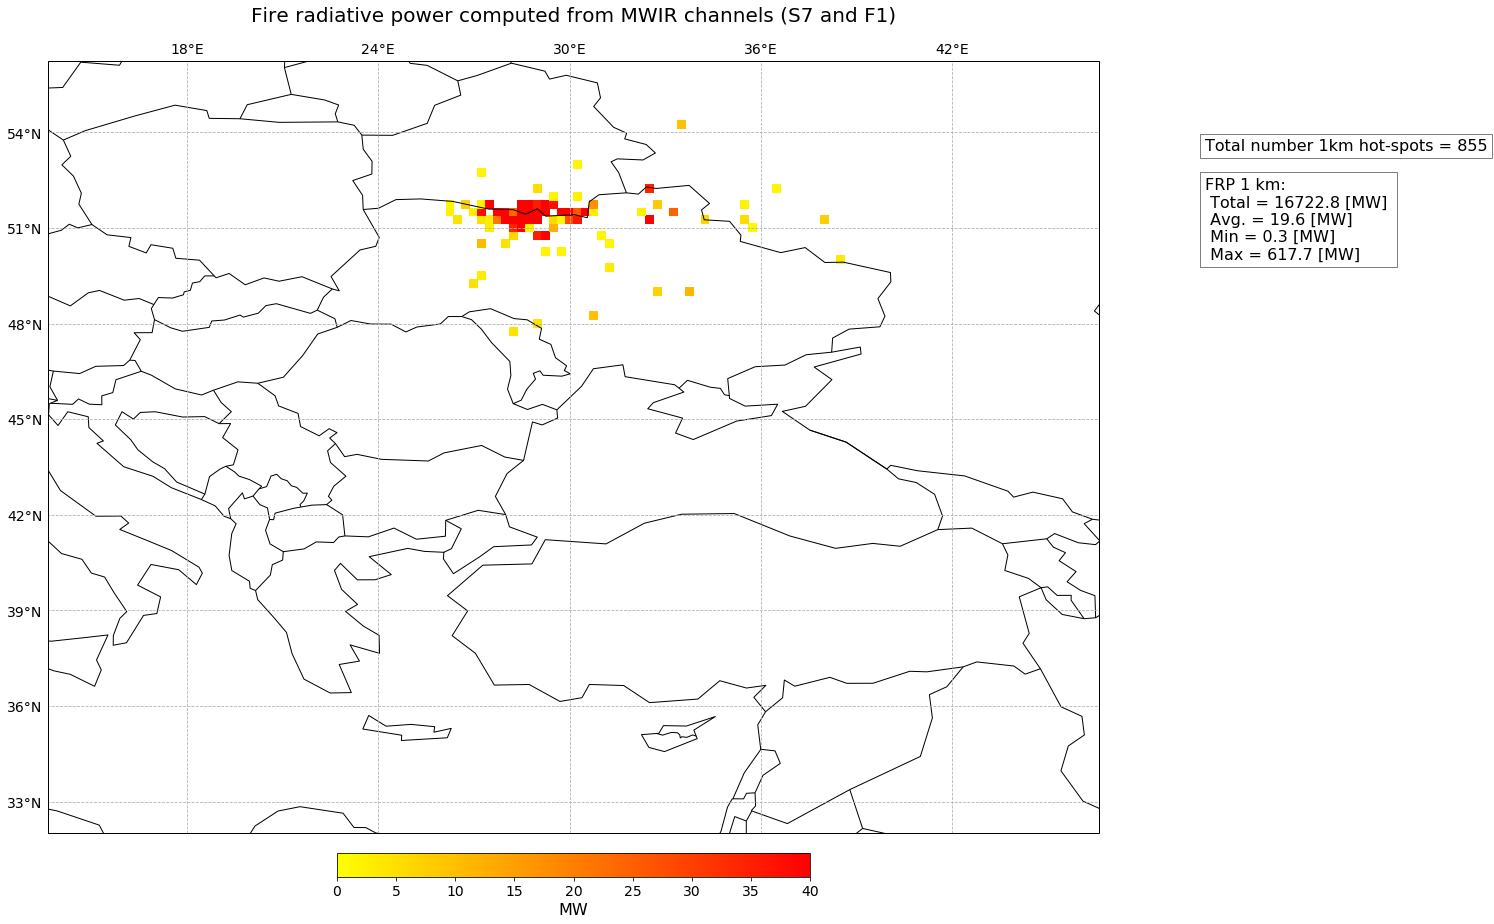

In [14]:
long_name = frp_mwir.long_name
unit = frp_mwir.units
vmax = FRP_plot_max_grid

visualize_s3_frp(D_mwir[:,:],lat_grid, lon_grid, unit, long_name, textstr_1, textstr_2, FRP_plot_max_grid)

<br>

Let us now repeat the processing steps above and let us process and visualize the `FRP computed from the SWIR channel`.

## <a id='load_swir'></a>Load, mask and regrid `FRP computed from SWIR channel (2.25 um)`

Load the `FRP_SWIR` data variable from the loaded `netCDF` file.

In [15]:
frp_swir = frp_xr['FRP_SWIR']
frp_swir

<xarray.DataArray 'FRP_SWIR' (fires: 917)>
array([-1., -1., -1., ..., -1., -1., -1.])
Dimensions without coordinates: fires
Attributes:
    long_name:  Fire radiative power computed from SWIR channel (S6)
    units:      MW

Filter only valid pixels and filter all pixels with -1 out.

In [16]:
masked_frp_swir = generate_masked_array(frp_swir, frp_swir, -1., operator='!=', drop=True)
masked_frp_swir

<xarray.DataArray 'FRP_SWIR' (fires: 917)>
array([         nan,          nan,          nan,          nan,
                nan,          nan,          nan,   1.78237245,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,  14.49562811,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
         3.33291371,          nan,          nan,          nan,
         2.14934458,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,   2.56304328,   3.90616017,          nan,
                nan,          nan,          nan,          nan,
            

<xarray.DataArray 'FRP_SWIR' (fires: 288)>
array([  1.78237245,  14.49562811,   3.33291371,   2.14934458,
         2.56304328,   3.90616017,  25.01275899,   3.29803704,
         2.18113198,  10.08653529,   4.08239337,   4.14176581,
        17.53911234,  24.31956132,  39.66215248,  33.82620415,
        30.35514323,  16.5899628 ,  10.69805581,  16.46655874,
         8.61558456,  12.39634869,  15.37661605,   2.09217688,
         5.39678422,   9.31182407,   5.53583791,   4.73188584,
         2.24392179,   4.82475667,   2.02795424,  10.90125825,
        42.19268652,  78.43669098,   5.26424931,   6.44829128,
         4.02902254,   4.40256972, 114.4474222 ,  14.36229928,
         4.00833544,   2.1363703 ,  63.64643835,  40.05282978,
         4.82775712,   4.93608558,   7.24567586,   9.50146626,
         2.60117086,   4.69945244,  22.84236851,   5.26941898,
         3.54188678,   3.83032744,  17.2442377 ,   5.01388154,
         3.33508042,   3.35060416,   3.05037712,  98.84662998,
        28.48529574,  97.98744278,  12.09501137,   6.53972056,
        16.7393141 ,   5.95320505,  96.66842125, 145.75499258,
        85.90668195,  58.88739258,  30.70970452,  12.04985274,
         2.99779824, 146.44188578,  36.4594933 ,  14.35096281,
        21.78522798,  26.85353738,  34.81490182,  18.12812372,
        13.99992626,  91.22349634,   2.19820466,   6.35377756,
         4.80655375,  41.52659897,  13.70785315,   9.7136809 ,
         8.82114718, 107.32873477,  15.51646531,  19.14468607,
         5.13357072,  40.08259239,   4.97242004,   4.74762406,
        38.24612328,  13.79858735,  13.0006634 ,  27.40667331,
        26.84951502,   5.73106311,   2.08490452,  10.1322903 ,
        21.52357668,  13.37529576,  24.45889957,  39.10043741,
        21.64073254,  13.58482208,  67.85170522,   8.92357526,
         7.89745147,  26.42634462,  10.66506034,   7.55011037,
        10.55000404,  55.1863829 ,  75.2117944 ,  41.51589391,
        20.94910821,   9.4971481 ,  29.31159688,  31.50174399,
         7.51000681,  11.46514237,  35.71471576,  11.44980293,
         8.82946429,  10.62265751,  11.1459886 ,  17.6408901 ,
         6.25021179,  21.25473462,   2.94717052,  88.54891511,
         7.54973277,   8.00507226,   5.58955559,   7.76049407,
         3.05928919,   5.4430782 ,   3.61016752,   2.7216596 ,
        31.39867154,   7.22582021,   4.13526546,  14.33701778,
        20.13845849,  72.46796732,   4.47576963,  67.5564387 ,
        28.01804188,   2.25740025,   2.34719327, 117.60202517,
        54.72909002,  13.84067223,  20.60802464,  12.13790807,
        24.22095235,  37.0962976 ,  10.12366156,  11.35315314,
         2.92835712,   3.83651895,   5.32620158,   4.96393511,
        15.47518518,   7.52343537,  23.38207364,   3.61340307,
         7.98475558,  16.6234177 ,  18.44943282,   5.08946223,
         9.21856561,   5.83704025,  21.99874105,   7.85276507,
         6.02900946,   2.14739687,   8.38042058,  12.11912449,
         8.46475137,  28.55253134,  42.1047604 ,   6.05490333,
         6.51933286,  14.69002924,  11.14603919,  12.13639449,
        35.74213557,  15.06008708,   3.55722035,   5.70369079,
        42.83250333,   6.98016114,   2.25297321,  12.85019691,
        19.61592136,  24.97742131,   9.14822545,   8.30422104,
         5.83742926,   9.25604575,  31.38730627,   3.30029445,
         4.80446191,  11.62447116,  12.47087527,   2.78774938,
        12.34110274,  14.70438707,   9.69523975,  11.95392955,
         2.62882864,   2.6944352 ,   2.83754263,   3.84452064,
         9.37167223,   2.5706428 ,   4.11995493,  42.59326735,
         7.20035676,   5.78504398,   5.79775833,   4.92857802,
         8.42913429,   2.28509322,   2.19690111,   2.17780918,
        10.21241492,  40.94081832,   4.77733552,   4.88029332,
         2.13564605,   2.91995814,  12.86637011,  25.16388654,
         3.08774416,   4.15847944,  15.66028289,  60.99995361,
        15.4219094 ,   3.44949106,   3.54539624,  27.82770275,
         7.11206998,   3.23168261,  11.46899361,  3

Compute the number of total fires and per category.

In [17]:
n_fire_tot           = len(lat_frp[:])
n_fire_SWIR          = len(masked_frp_swir.to_masked_array().compressed())

n_fire_tot, n_fire_SWIR

(917, 288)

Apply the gridding function `slstr_frp_gridding` and grid the `FRP computed from the SWIR channel`.

In [18]:
FRP_SWIR_grid, lat_grid, lon_grid = slstr_frp_gridding(frp_swir, 'swir', lat_min, lat_max, lon_min, lon_max, sampling_lat_FRP_grid,
                                  sampling_lon_FRP_grid, n_fire_SWIR)

FRP_SWIR_grid, lat_grid, lon_grid

(array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],
       dtype=float32),
 array([[33.125, 33.125, 33.125, ..., 33.125, 33.125, 33.125],
        [33.375, 33.375, 33.375, ..., 33.375, 33.375, 33.375],
        [33.625, 33.625, 33.625, ..., 33.625, 33.625, 33.625],
        ...,
        [54.625, 54.625, 54.625, ..., 54.625, 54.625, 54.625],
        [54.875, 54.875, 54.875, ..., 54.875, 54.875, 54.875],
        [55.125, 55.125, 55.125, ..., 55.125, 55.125, 55.125]],
       dtype=float32),
 array([[15.125, 15.375, 15.625, ..., 44.625, 44.875, 45.125],
        [15.125, 15.375, 15.625, ..., 44.625, 44.875, 45.125],
        [15.125, 15.375, 15.625, ..., 44.625

Mask out all invalid pixels for plotting.

In [19]:
mask_valid = np.where(FRP_SWIR_grid[:,:] != -9999., False, True)
D_swir          = np.ma.masked_array(FRP_SWIR_grid[:,:], mask=mask_valid)

Calculate some statistics and add them to a string that can be integrated in the final plot.

In [20]:
textstr_1 = 'Total number 1km hot-spots = ' + str(n_fire_SWIR)


FRP_sum      = np.sum(masked_frp_swir.to_masked_array().compressed())
FRP_mean     = np.mean(masked_frp_swir.to_masked_array().compressed())
FRP_std      = np.std(masked_frp_swir.to_masked_array().compressed())
FRP_min      = np.min(masked_frp_swir.to_masked_array().compressed())
FRP_max      = np.max(masked_frp_swir.to_masked_array().compressed())

FRP_sum_str  = '%.1f' % FRP_sum
FRP_mean_str = '%.1f' % FRP_mean
FRP_std_str  = '%.1f' % FRP_std
FRP_min_str  = '%.1f' % FRP_min
FRP_max_str  = '%.1f' % FRP_max

textstr_2 = 'FRP 1 km: \n Total = '+FRP_sum_str+' [MW] \n Avg. = '+ FRP_mean_str + ' [MW] \n Min = ' + FRP_min_str + ' [MW] \n Max = ' + FRP_max_str + ' [MW]'



Apply the plotting function `visualize_s3_frp` and take some attributes from the data variable's attributes.

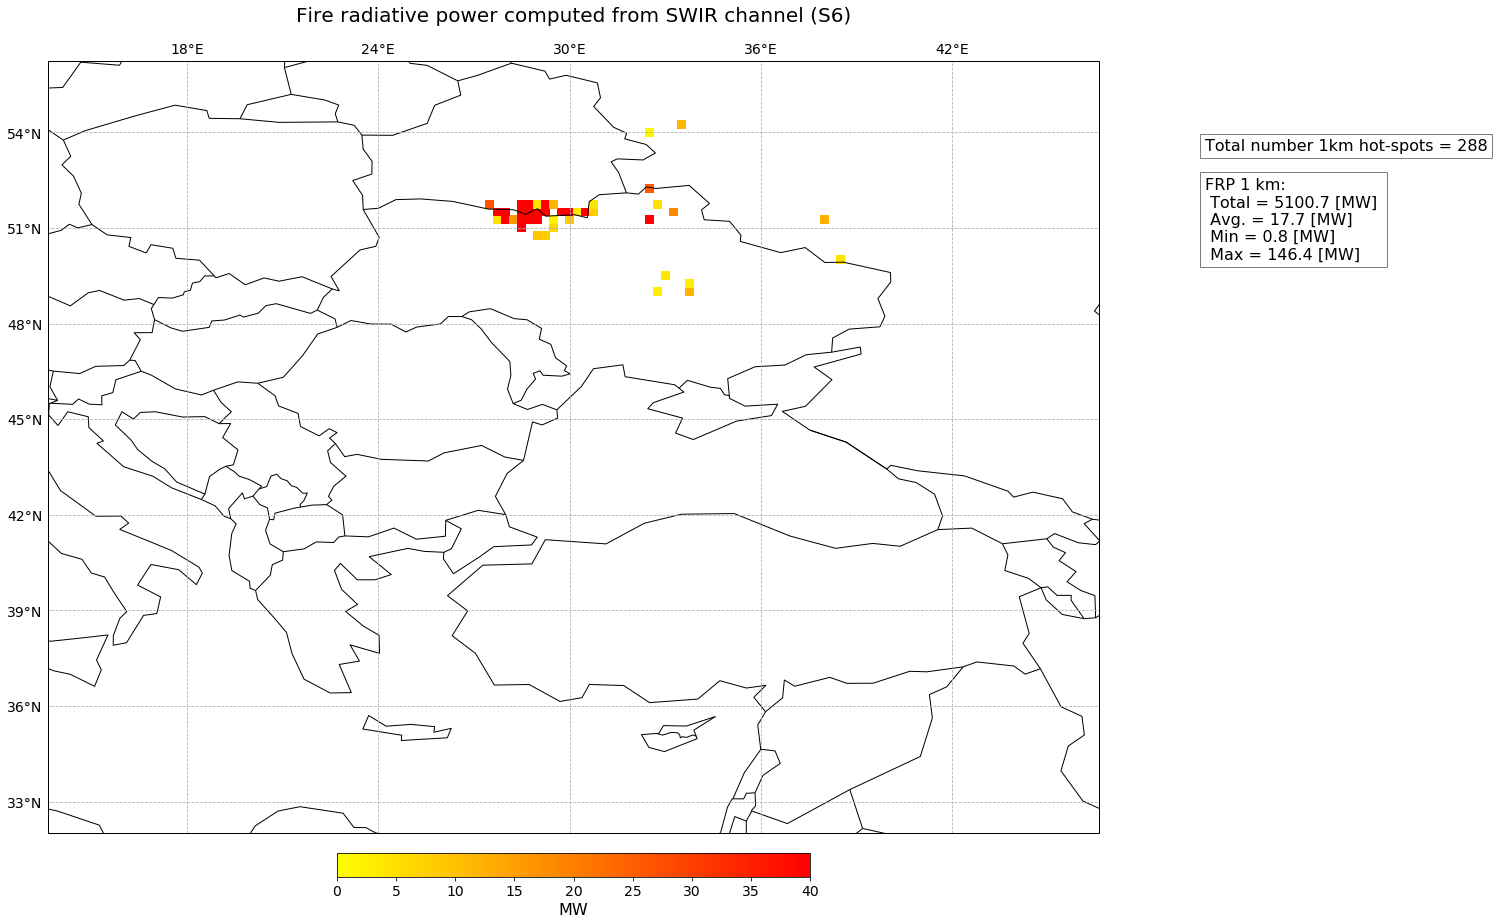

In [21]:
long_name = frp_swir.long_name
unit = frp_swir.units
vmax = FRP_plot_max_grid

visualize_s3_frp(D_swir[:,:],lat_grid, lon_grid, unit, long_name, textstr_1, textstr_2, FRP_plot_max_grid)

<br>

Let us repeat the same processing steps for the `FRP computed from SWIR channel`, but with the SAA filter applied.

<br>

## <a id='load_swir_nosaa'></a> Load, mask and regrid `FRP computed from SWIR channel (2.25 um) with SAA filter applied`

Load the flag for the `South Atlantic Anomaly (SAA)` with the data variable name `FLAG_SWIR_SAA`. 

In [22]:
FLAG_FRP_SWIR_SAA_nc = frp_xr['FLAG_SWIR_SAA']
FLAG_FRP_SWIR_SAA_nc

<xarray.DataArray 'FLAG_SWIR_SAA' (fires: 917)>
array([-1, -1, -1, ..., -1, -1, -1], dtype=int16)
Dimensions without coordinates: fires
Attributes:
    long_name:      Flag South Atlantic Anomaly (SAA) suspected from SWIR cha...
    flag_values:    [-1  0  1  2  3  4]
    flag_meanings:  NA Unlikely Possible Spare Spare Spare

Apply the mask for only valid pixels of the `FRP SWIR` data variable and include the `FLAG_SWIR_SAA` as additional informaion.

In [23]:
mask_frp_swir_nosaa = xr.where((frp_swir!=-1.) & (FLAG_FRP_SWIR_SAA_nc==0), 1, 0)
mask_frp_swir_nosaa

masked_frp_swir_nosaa = xr.where(mask_frp_swir_nosaa==1, frp_swir, np.nan)
masked_frp_swir_nosaa

<xarray.DataArray (fires: 917)>
array([         nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,  14.49562811,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
         3.33291371,          nan,          nan,          nan,
         2.14934458,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,   2.56304328,   3.90616017,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,  25.01275899,          nan,          nan,
                nan,          nan,          nan,          nan,
         3.29803704,          nan,          nan,          nan,
                nan,          nan,   2.18113198,  10.08653529,
         4.08239337,          nan,   4.14176581,  17.53911234,
        24.31956132,  39.66215248,  33.82620415,  30.35514323,
                nan,          nan,  16.5899628 ,  10.69805581,
        16.46655874,   8.61558456,  12.39634869,  15.37661605,
                nan,          nan,   2.09217688,   5.39678422,
         9.31182407,   5.53583791,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,   4.73188584,
                nan,          nan,          nan,          nan,
                nan,   2.24392179,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,   2.02795424,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
        10.90125825,          nan,          nan,          nan,
                nan,          nan,  42.19268652,  78.43669098,
                nan,          nan,          nan,   5.26424931,
         6.44829128,          nan,   4.02902254,   4.40256972,
       114.4474222 ,  14.36229928,          nan,          nan,
                nan,          nan,   4.00833544,          nan,
                nan,          nan,          nan,   2.1363703 ,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
        63.64643835,  40.05282978,   4.82775712,          nan,
                nan,          nan,          nan,   4.93608558,
         7.24567586,          nan,   9.50146626,          nan,
         2.60117086,   4.69945244,          nan,          nan,
                nan,          nan,          nan,  22.84236851,
                nan,   5.26941898,          nan,          nan,
         3.54188678,   3.83032744,          nan,          nan,
                nan,          nan,  17.2442377 ,          nan,
                nan,          nan,          nan,          nan,
         5.01388154,   3.33508042,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,   3.35060416,
                nan,   3.05037712,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,  98.84662998,  28.48529574,

Let us compute the total number fires and also of the category of `FRP SWIR` with filter applied.

In [24]:
n_fire_tot           = len(lat_frp[:])
n_fire_SWIR_NoSAA    = len(masked_frp_swir_nosaa.to_masked_array().compressed())

n_fire_tot, n_fire_SWIR_NoSAA

(917, 284)

Apply the gridding function `slstr_frp_gridding` to grid the filtered `FRP SWIR` data.

In [25]:
FRP_SWIR_NoSAA_grid, lat_grid, lon_grid = slstr_frp_gridding(frp_swir, 'swir_nosaa', lat_min, lat_max, lon_min, lon_max, sampling_lat_FRP_grid,
                                  sampling_lon_FRP_grid, n_fire_SWIR_NoSAA, flag=FLAG_FRP_SWIR_SAA_nc)
FRP_SWIR_NoSAA_grid, lat_grid, lon_grid

(array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],
       dtype=float32),
 array([[33.125, 33.125, 33.125, ..., 33.125, 33.125, 33.125],
        [33.375, 33.375, 33.375, ..., 33.375, 33.375, 33.375],
        [33.625, 33.625, 33.625, ..., 33.625, 33.625, 33.625],
        ...,
        [54.625, 54.625, 54.625, ..., 54.625, 54.625, 54.625],
        [54.875, 54.875, 54.875, ..., 54.875, 54.875, 54.875],
        [55.125, 55.125, 55.125, ..., 55.125, 55.125, 55.125]],
       dtype=float32),
 array([[15.125, 15.375, 15.625, ..., 44.625, 44.875, 45.125],
        [15.125, 15.375, 15.625, ..., 44.625, 44.875, 45.125],
        [15.125, 15.375, 15.625, ..., 44.625

Mask out the invalid pixels for plotting.

In [26]:
mask_valid = np.where(FRP_SWIR_NoSAA_grid[:,:] != -9999., False, True)
D_swir_NoSAA          = np.ma.masked_array(FRP_SWIR_NoSAA_grid[:,:], mask=mask_valid)

Calculate some statistics and add them to a string that can be integrated in the final plot.

In [27]:
textstr_1 = 'Total number 1km hot-spots = ' + str(n_fire_SWIR_NoSAA)


FRP_sum      = np.sum(masked_frp_swir_nosaa.to_masked_array().compressed())
FRP_mean     = np.mean(masked_frp_swir_nosaa.to_masked_array().compressed())
FRP_std      = np.std(masked_frp_swir_nosaa.to_masked_array().compressed())
FRP_min      = np.min(masked_frp_swir_nosaa.to_masked_array().compressed())
FRP_max      = np.max(masked_frp_swir_nosaa.to_masked_array().compressed())

FRP_sum_str  = '%.1f' % FRP_sum
FRP_mean_str = '%.1f' % FRP_mean
FRP_std_str  = '%.1f' % FRP_std
FRP_min_str  = '%.1f' % FRP_min
FRP_max_str  = '%.1f' % FRP_max

textstr_2 = 'FRP 1 km: \n Total = '+FRP_sum_str+' [MW] \n Avg. = '+ FRP_mean_str + ' [MW] \n Min = ' + FRP_min_str + ' [MW] \n Max = ' + FRP_max_str + ' [MW]'


Apply the function `visualize_s3_frp` to visualize the data and make use of the data variable's attributes.

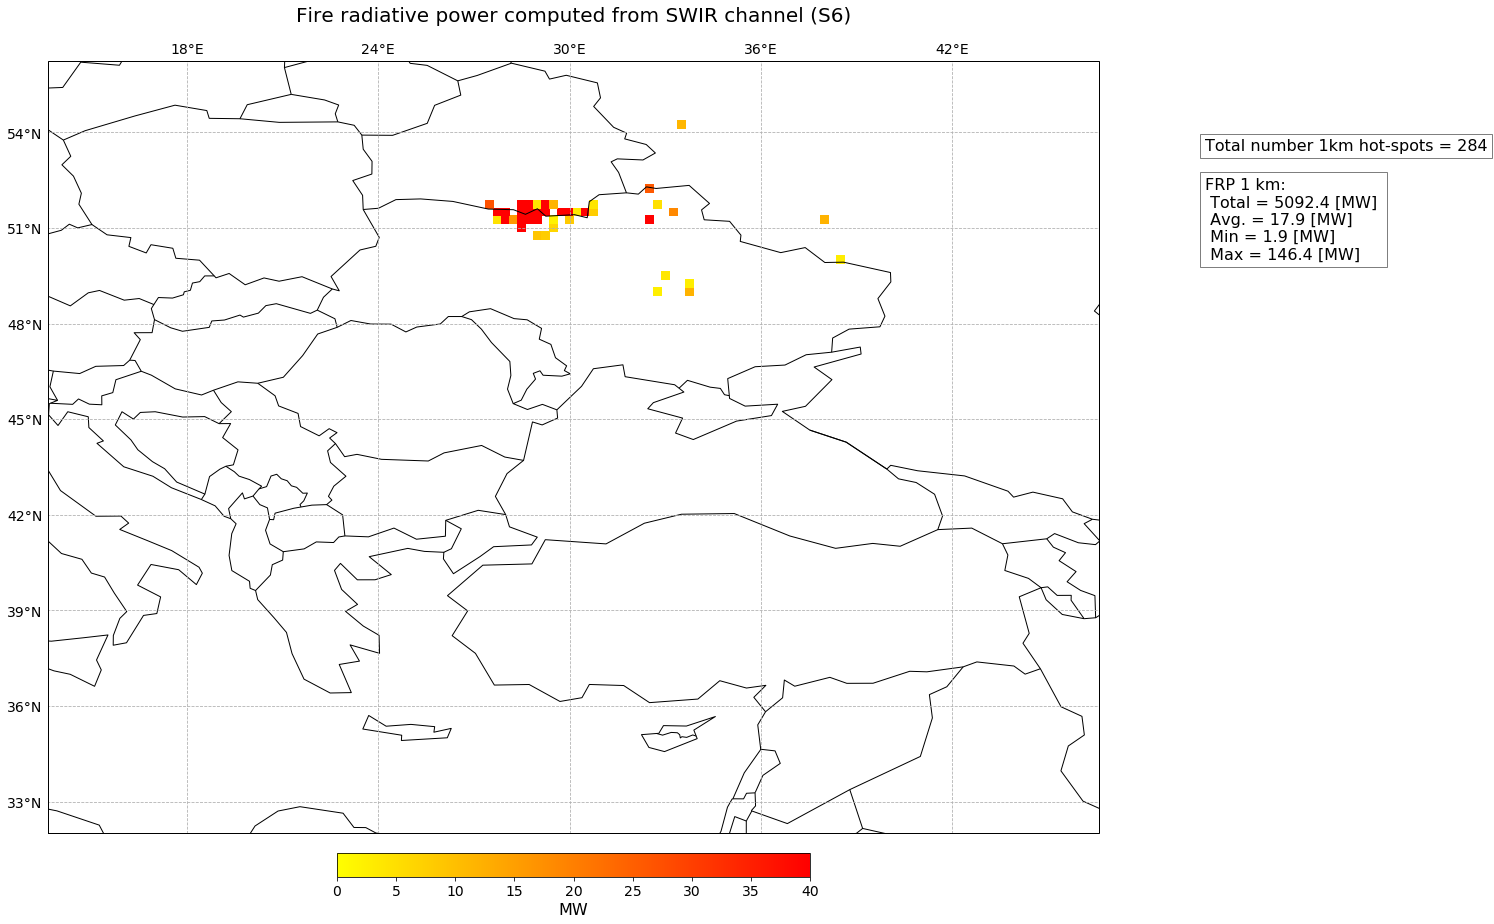

In [28]:
long_name = frp_swir.long_name
unit = frp_swir.units
vmax = FRP_plot_max_grid

visualize_s3_frp(D_swir_NoSAA[:,:],lat_grid, lon_grid, unit, long_name + 'no SAA', textstr_1, textstr_2, FRP_plot_max_grid)

<br>

<a href="./51_sentinel3_slstr_frp.ipynb"><< 51 - Sentinel-3 SLSTR FRP </a><span style="float:right;"><a href="./53_sentinel3_olci_rgb.ipynb">53 - Sentinel-3 OLCI RGB >></a></span>

<hr>

<img src='./img/copernicus_logo.png' alt='Logo EU Copernicus' align='right' width='20%'><br><br><br>

<p style="text-align:right;">This project is licensed under the <a href="./LICENSE">MIT License</a> and is developed under a Copernicus contract.